In [56]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_2'
opt.dataroot='/home/host/data/training/height29_30km_pix2pix_sat_all_med29/'
opt.dataset_mode='aligned'
opt.name='0106_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
opt.attention =False
opt.useVAE2=True
opt.epoch = '200'
sat_model = create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='test'
test_dataset = create_dataset(opt)
from tqdm import tqdm
mius_sat=[]
model=sat_model
model.eval()

for i, data in tqdm(enumerate(train_dataset)):
    model.set_input(data)  # unpack data from data loader
    model.test()          
    mius_sat.append(model.netS.module.miu.detach())
for i, data in tqdm(enumerate(val_dataset)):
    model.set_input(data)  # unpack data from data loader
    model.test()          
    mius_sat.append(model.netS.module.miu.detach())
for i, data in tqdm(enumerate(test_dataset)):
    model.set_input(data)  # unpack data from data loader
    model.test()          
    mius_sat.append(model.netS.module.miu.detach())

    
    


----------------- Options ---------------
             aspect_ratio: 1.0                           
                attention: False                         
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
              

0it [00:00, ?it/s]

initialize network with normal
model [VAEPix2PixModel] was created
loading the model from ./checkpoints/0106_vae_sat_all/200_net_S.pth
loading the model from ./checkpoints/0106_vae_sat_all/200_net_G.pth
---------- Networks initialized -------------
[Network S] Total number of parameters : 2.848 M
[Network G] Total number of parameters : 42.715 M
-----------------------------------------------
dataset [AlignedDataset] was created
dataset [AlignedDataset] was created
dataset [AlignedDataset] was created


2526it [02:08, 19.61it/s]
632it [00:33, 19.04it/s]
0it [00:00, ?it/s]


In [57]:

opt.dataroot='/home/host/data/training/height29_30km_pix2pix_hei_all_med29/'
opt.dataset_mode='aligned'
opt.name='1213_vae_hei_all'
opt.netG='unet_256'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=1
opt.preprocess=[]
opt.epoch = "latest"
opt.attention = False
opt.useVAE2=False
opt.epoch='latest'
hei_model = create_model(opt)
hei_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='test'
test_dataset = create_dataset(opt)

mius_hei=[]
model=hei_model
model.eval()
for i, data in tqdm(enumerate(train_dataset)):
    model.set_input(data)  # unpack data from data loader
    model.test()          
    mius_hei.append(model.netS.module.miu.detach())
for i, data in tqdm(enumerate(val_dataset)):
    model.set_input(data)  # unpack data from data loader
    model.test()          
    mius_hei.append(model.netS.module.miu.detach())
for i, data in tqdm(enumerate(test_dataset)):
    model.set_input(data)  # unpack data from data loader
    model.test()          
    mius_hei.append(model.netS.module.miu.detach())

0it [00:00, ?it/s]

initialize network with normal
model [VAEPix2PixModel] was created
loading the model from ./checkpoints/1213_vae_hei_all/latest_net_S.pth
loading the model from ./checkpoints/1213_vae_hei_all/latest_net_G.pth
---------- Networks initialized -------------
[Network S] Total number of parameters : 2.849 M
[Network G] Total number of parameters : 54.416 M
-----------------------------------------------
dataset [AlignedDataset] was created
dataset [AlignedDataset] was created
dataset [AlignedDataset] was created


2526it [00:35, 71.71it/s]
632it [00:08, 70.81it/s]
0it [00:00, ?it/s]


In [58]:
import torch
lat_dim=8
latent=torch.cat([torch.cat(mius_sat,dim=0).transpose(0,1).reshape(lat_dim,-1).t(),torch.cat(mius_hei,dim=0).transpose(0,1).reshape(lat_dim,-1).t()*0.1],dim=1)
latent_mean=latent.mean(0)
latent-=latent_mean

In [59]:
import matplotlib.pyplot as plt
r=5
def scat(X):
    plt.xlim(-r,r)
    plt.ylim(-r,r)
    plt.scatter(X.cpu()[:,0],X.cpu()[:,1], alpha=0.2,edgecolors='none')
def PCA_svd(X, k, center=True):
    n = X.size()[0]
    ones = torch.ones(n).view([n,1])
    h = ((1/n) * torch.mm(ones, ones.t())) if center  else torch.zeros(n*n).view([n,n])
    H = torch.eye(n) - h
    #H = H.cuda()
    X_center =  torch.mm(H.double(), X.double())
    u, s, v = torch.svd(X_center)
    components  = v[:k].t()
    return components

In [60]:
U=PCA_svd(latent.cpu(), 8)

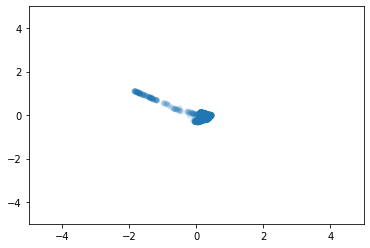

In [61]:
scat((latent)[0:1000].cpu().double())


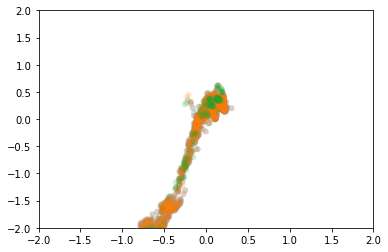

In [62]:
r=2
a=0
b=100
c=3000
d=2600
scat((torch.mm(U.t(),latent[a:a+d].t().cpu().double())).t())
scat((torch.mm(U.t(),latent[b:b+d].t().cpu().double())).t())
scat((torch.mm(U.t(),latent[c:c+d].t().cpu().double())).t())

In [63]:
latent_mean

tensor([-0.5657,  0.0544, -0.2818, -0.5111,  0.1089,  0.2850,  0.0197,  0.2487,
         0.0034,  0.0323,  0.0561,  0.0769, -0.0871,  0.0646, -0.0586, -0.0188],
       device='cuda:1')

In [8]:
latent.shape

torch.Size([3158, 16])

In [9]:
(torch.mm(U.t(),latent[a:a+d].t().cpu().double())).t().shape

torch.Size([1000, 8])

In [38]:
scat(torch.mm(X,U.t()))

NameError: name 'X' is not defined

In [31]:
latent_mean

tensor([-0.5657,  0.0544, -0.2818, -0.5111,  0.1089,  0.2850,  0.0197,  0.2487,
         0.0034,  0.0323,  0.0561,  0.0769, -0.0871,  0.0646, -0.0586, -0.0188],
       device='cuda:1')

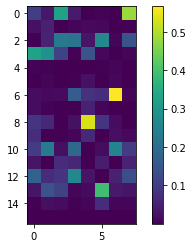

In [64]:
plt.imshow(U**2)
plt.colorbar()

In [65]:
torch.save((latent_mean,U),'latent_data/0106_200')

In [46]:
torch.save(mius_hei[0:10],'latent_data/lat10')

In [73]:
torch.nn.Tanh()(torch.tensor(1.))

tensor(0.7616)

In [12]:
torch.var(torch.tensor([[1,2.]]))

tensor(0.5000)

In [190]:
model.netS.module.upsampler

Upsample(scale_factor=64.0, mode=bicubic)

In [197]:
model.netS.module.upsampler(latent[0][0:16].view(1,1,4,4)).shape

torch.Size([1, 1, 256, 256])

In [249]:
slider=torch.tensor([[0.]*10]).double()
slider[0,0]=1
slider[0,1]=-1 
latent=torch.mm(U,slider.t())


In [29]:
latent.mean(0)

tensor([ 0.0000e+00,  4.5298e-09,  5.4358e-09,  9.0596e-10,  2.4159e-09,
        -9.3616e-09,  0.0000e+00,  7.2477e-09,  3.0199e-10, -6.0397e-10,
        -1.8119e-09,  3.0199e-09, -6.0397e-09, -4.8318e-09,  1.2079e-09,
        -7.5497e-10], device='cuda:1')

In [212]:

model.forward(latent)

tensor([[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], dtype=torch.float64)

In [2]:
for i, data in tqdm(enumerate(train_dataset)):
    break

0it [00:00, ?it/s]


In [18]:
import torch
model.set_input(data)
model.forward(torch.tensor([[-0.0010],
        [ 0.5],
        [-0.0356],
        [-0.0015],
        [-0.0081],
        [ 0.0255],
        [0.3],
        [ 0.0295],
        [-0.0169],
        [-0.0107],
        [ 0.1654],
        [0.5],
        [ 0.0121],
        [-0.3842],
        [ 0.0416],
        [ 0.3695]]*16, dtype=torch.float).cuda())

In [22]:
import torchvision
def p(x):
    return torchvision.transforms.ToPILImage()(x[0].detach().cpu()/2+0.5)

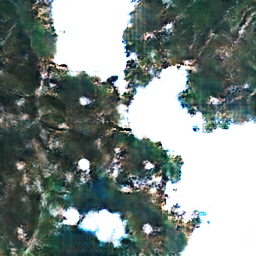

In [19]:
p(model.get_current_visuals()['fake_B'])

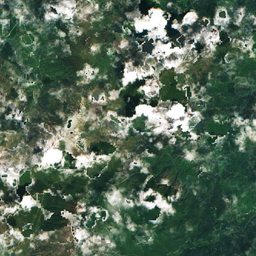

In [254]:
p(model.get_current_visuals()['real_B'])

In [261]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_256'
opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1026_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
sat_model = models.create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='test'
test_dataset = create_dataset(opt)
from tqdm import tqdm
mius_sat=[]
model=sat_model
model.eval()

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
 

In [25]:
for i, data in tqdm(enumerate(train_dataset)):
    if i==1:
        dataaergrg

1it [00:00, 48.13it/s]


NameError: name 'dataaergrg' is not defined

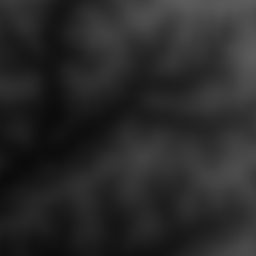

In [26]:
p(data['A'])

In [7]:
latent.shape

torch.Size([1579, 32])

In [19]:
import numpy as np

In [34]:
np.random.uniform(-10,10)

0.6900409417368317

In [67]:
for i, data in tqdm(enumerate(train_dataset)):
    print(data['A_paths'])
    if i ==10:
        break


10it [00:00, 81.31it/s]

['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N26E098.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N26E099.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N26E100.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N26E101.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N27E085.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N27E086.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N27E087.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N27E098.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N27E099.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N27E100.png']
['/home/host/data/training/height29_30km_pix2pix_sat_all_med29/train/29_0000_N27E101.png']

In [45]:
data

{'A': tensor([[[[ 0.0588,  0.0902,  0.0824,  ...,  0.3020,  0.3255,  0.3255],
           [ 0.0588,  0.0588,  0.0510,  ...,  0.3255,  0.3490,  0.3647],
           [ 0.0275,  0.0275,  0.0275,  ...,  0.3412,  0.3647,  0.3882],
           ...,
           [-0.2078, -0.2471, -0.2235,  ...,  0.6863,  0.7255,  0.7569],
           [-0.2157, -0.2314, -0.2235,  ...,  0.6863,  0.7176,  0.7569],
           [-0.2235, -0.2078, -0.2000,  ...,  0.6706,  0.7020,  0.7412]]]]),
 'B': tensor([[[[ 0.5373,  0.7176,  0.7647,  ..., -0.2235, -0.2235, -0.4353],
           [-0.3569,  0.2627,  0.4039,  ..., -0.3882, -0.2863, -0.4431],
           [-0.6000, -0.4118,  0.5373,  ..., -0.6078, -0.5216, -0.2627],
           ...,
           [-0.5843, -0.5843, -0.6157,  ...,  0.3020,  0.7176,  0.5216],
           [-0.5922, -0.5765, -0.5843,  ...,  0.4353,  0.5216,  0.6471],
           [-0.5765, -0.6392, -0.6235,  ...,  0.3804,  0.0353,  0.2941]],
 
          [[ 0.6157,  0.7333,  0.7961,  ..., -0.0667, -0.0902, -0.2314],
  

In [48]:
data

{'A': tensor([[[[-0.1373, -0.1216, -0.1216,  ...,  0.0902,  0.0667,  0.0431],
           [-0.1686, -0.1529, -0.1608,  ...,  0.0824,  0.0588,  0.0431],
           [-0.2078, -0.2078, -0.2078,  ...,  0.0980,  0.0980,  0.0902],
           ...,
           [ 0.2941,  0.3176,  0.3412,  ..., -0.2235, -0.2627, -0.2941],
           [ 0.2941,  0.3176,  0.3333,  ..., -0.2392, -0.2706, -0.3020],
           [ 0.2627,  0.2863,  0.3020,  ..., -0.2314, -0.2706, -0.3098]]]]),
 'B': tensor([[[[-0.4118, -0.5765, -0.2549,  ..., -0.8745, -0.8510, -0.8510],
           [-0.6157, -0.4118, -0.3412,  ..., -0.8667, -0.8745, -0.8745],
           [-0.3176, -0.2784, -0.4039,  ..., -0.8745, -0.8745, -0.8745],
           ...,
           [-0.6784, -0.7098, -0.6627,  ..., -0.5137, -0.3804, -0.4824],
           [-0.5216, -0.5373, -0.4510,  ..., -0.4824, -0.4353, -0.2549],
           [-0.5059, -0.6000, -0.5765,  ..., -0.5294, -0.4980, -0.2941]],
 
          [[-0.3255, -0.3961, -0.1529,  ..., -0.7569, -0.7333, -0.7490],
  